## Neural Machine Transalation with attention

In [1]:
import pandas as pd
import numpy as np
import re
import string
from unicodedata import normalize

read the data from the file, using pandas, and since the english text are separated from the french with tabs, we set the value of the delimeter has '\t'.

In [2]:
df = pd.read_csv("fra.txt",delimiter="\t",header=None)
df.head()

,0,1
0,Go.,Va !
1,Run!,Cours !
2,Run!,Courez !
3,Fire!,Au feu !
4,Help!,À l'aide !


since we don't want to used the whole data we select a small portion of size 2000

In [3]:
df = df.iloc[:2000,:]
print(len(df))
df.head()

2000


,0,1
0,Go.,Va !
1,Run!,Cours !
2,Run!,Courez !
3,Fire!,Au feu !
4,Help!,À l'aide !


In [4]:
def clean_txt(text):
    
    re_print = re.compile('[^%s]' % re.escape(string.printable))
    table = str.maketrans('', '', string.punctuation)
    
    text = normalize('NFD', text).encode('ascii', 'ignore')
    text = text.decode('UTF-8')
    text = text.split()
    # convert to lowercase
    text = [word.lower() for word in text]
    # remove punctuation from each token
    text = [word.translate(table) for word in text]
    # remove non-printable chars form each token
    text = [re_print.sub('', w) for w in text]
    # remove tokens with numbers in them
    text = [word for word in text if word.isalpha()]
    
    return ' '.join(text)

create a clean format of the data(french and english)

In [5]:
french = [clean_txt(text) for text in df[1]]
english = [clean_txt(text) for text in df[0]]

In [6]:
french[0]

'va'

## Split the data

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
fra_train,fra_test,eng_train,eng_test= train_test_split(french,english,test_size=0.1,random_state=5)

In [9]:
fra_train,fra_val,eng_train,eng_val = train_test_split(fra_train,eng_train,test_size=0.1,random_state=5)

In [10]:
print("fra_train",len(fra_train))
print("eng_test",len(eng_test))
print("fra_val",len(fra_val))

fra_train 1620
eng_test 200
fra_val 180


In [11]:
def max_length(lines):
    length = [ len(line) for line in lines]
    return max(length)

In [12]:
max_french_len = max_length(french)
max_english_len = max_length(english)

print("max french length",max_french_len)
print("max_english length",max_english_len)

max french length 34
max_english length 11


## Utility function for data encoding and decoding

In [1]:
import numpy as np

CHAR_CODE_START = 1
CHAR_CODE_PADDING = 0


def build_characters_encoding(names):
    
    count = 2
    encoding = {}
    decoding = {1: 'START'}
    for c in set([c for name in names for c in name]):
        encoding[c] = count
        decoding[count] = c
        count += 1
    return encoding, decoding, count


def transform(encoding, data, vector_size):
   
    transformed_data = np.zeros(shape=(len(data), vector_size))
    for i in range(len(data)):
        for j in range(min(len(data[i]), vector_size)):
            transformed_data[i][j] = encoding[data[i][j]]
    return transformed_data


def decode(decoding, vector):
   
    text = ''
    for i in vector:
        if i == 0:
            break
        text += decoding[i]
    return text

In [14]:
INPUT_LENGTH = max_french_len
OUTPUT_LENGTH = max_english_len

## vectorize the generated data

In [15]:
input_encoding, input_decoding, input_dict_size = build_characters_encoding(french)
output_encoding, output_decoding, output_dict_size = build_characters_encoding(english)

print('franch character dict size:', input_dict_size)
print('english character dict size:', output_dict_size)

encoded_training_input = transform(
    input_encoding, fra_train, vector_size=INPUT_LENGTH)
encoded_training_output = transform(
    output_encoding, eng_train, vector_size=OUTPUT_LENGTH)
print('encoded_training_input', encoded_training_input.shape)
print('encoded_training_output', encoded_training_output.shape)

encoded_validation_input = transform(
    input_encoding, fra_val, vector_size=INPUT_LENGTH)
encoded_validation_output = transform(
    output_encoding, eng_val, vector_size=OUTPUT_LENGTH)

print('encoded_validation_input', encoded_validation_input.shape)
print('encoded_validation_output', encoded_validation_output.shape)

franch character dict size: 28
english character dict size: 29
encoded_training_input (1620, 34)
encoded_training_output (1620, 11)
encoded_validation_input (180, 34)
encoded_validation_output (180, 11)


In [16]:
input_encoding

{'d': 2,
 'q': 3,
 's': 4,
 ' ': 5,
 'b': 6,
 'a': 7,
 'h': 8,
 'l': 9,
 't': 10,
 'r': 11,
 'p': 12,
 'g': 13,
 'v': 14,
 'i': 15,
 'k': 16,
 'x': 17,
 'u': 18,
 'z': 19,
 'c': 20,
 'e': 21,
 'j': 22,
 'o': 23,
 'n': 24,
 'm': 25,
 'f': 26,
 'y': 27}

In [17]:
encoded_training_output[1],encoded_training_input[1]

(array([ 8., 26.,  6., 16.,  6.,  4., 12., 24., 25., 14.,  0.]),
 array([ 7., 15., 22., 21.,  5., 10., 23., 11., 10.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]))

## Define the model

In [18]:
from tensorflow.keras.layers import Input, Embedding, LSTM, TimeDistributed, Dense
from tensorflow.keras.models import Model, load_model

In [19]:
encoder_input = Input(shape=(INPUT_LENGTH,))
decoder_input = Input(shape=(OUTPUT_LENGTH,))

In [32]:
encoder = Embedding(input_dict_size, 256, input_length=INPUT_LENGTH, mask_zero=True)(encoder_input)
encoder,state_h1,state_c1 = LSTM(256,return_sequences=True,return_state=True)(encoder)
encoder , state_h,state_c = LSTM(256, return_sequences=True, return_state=True)(encoder)


print('encoder', encoder)
print('state_h',state_h)
print('state_c', state_c)

decoder = Embedding(output_dict_size, 256, input_length=OUTPUT_LENGTH, mask_zero=True)(decoder_input)
decoder = LSTM(256, return_sequences=True)(decoder, initial_state=[state_h1, state_c1])
decoder = LSTM(256,return_sequences=True)(decoder,initial_state=[state_h,state_c])

print('decoder', decoder)

encoder Tensor("lstm_19/transpose_2:0", shape=(?, 34, 256), dtype=float32)
state_h Tensor("lstm_19/while/Exit_3:0", shape=(?, 256), dtype=float32)
state_c Tensor("lstm_19/while/Exit_4:0", shape=(?, 256), dtype=float32)
decoder Tensor("lstm_21/transpose_2:0", shape=(?, 11, 256), dtype=float32)


In [33]:
from tensorflow.keras.layers import Activation, dot, concatenate

# Equation (7) with 'dot' score from Section 3.1 in the paper.
# Note that we reuse Softmax-activation layer instead of writing tensor calculation
attention = dot([decoder, encoder], axes=[2, 2])
attention = Activation('softmax', name='attention')(attention)
print('attention', attention)

context = dot([attention, encoder], axes=[2,1])
print('context', context)

decoder_combined_context = concatenate([context, decoder])
print('decoder_combined_context', decoder_combined_context)

# Has another weight + tanh layer as described in equation (5) of the paper
output = TimeDistributed(Dense(64, activation="tanh"))(decoder_combined_context)
output = TimeDistributed(Dense(output_dict_size, activation="softmax"))(output)
print('output', output)


attention Tensor("attention_1/truediv:0", shape=(?, 11, 34), dtype=float32)
context Tensor("dot_3/MatMul:0", shape=(?, 11, 256), dtype=float32)
decoder_combined_context Tensor("concatenate_1/concat:0", shape=(?, 11, 512), dtype=float32)
output Tensor("time_distributed_3/Reshape_1:0", shape=(?, 11, 29), dtype=float32)


In [34]:
model = Model(inputs=[encoder_input, decoder_input], outputs=[output])
model.compile(optimizer='adam', loss='binary_crossentropy')

In [35]:
training_encoder_input = encoded_training_input
training_decoder_input = np.zeros_like(encoded_training_output)
training_decoder_input[:, 1:] = encoded_training_output[:,:-1]
training_decoder_input[:, 0] = CHAR_CODE_START
training_decoder_output = np.eye(output_dict_size)[encoded_training_output.astype('int')]

validation_encoder_input = encoded_validation_input
validation_decoder_input = np.zeros_like(encoded_validation_output)
validation_decoder_input[:, 1:] = encoded_validation_output[:,:-1]
validation_decoder_input[:, 0] = CHAR_CODE_START
validation_decoder_output = np.eye(output_dict_size)[encoded_validation_output.astype('int')]

In [36]:
training_decoder_output.shape

(1620, 11, 29)

In [37]:
import os
if os.path.isfile('modelfra7.h5'):
    print("cool")
    model = load_model('modelfra7.h5')
else:
    history = model.fit(x=[training_encoder_input, training_decoder_input], y=[training_decoder_output],
          validation_data=([validation_encoder_input, validation_decoder_input], [validation_decoder_output]), batch_size=80, epochs=30)
    
model.save("modelfra7.h5")

/home/longbridge/tensorflow3/venv3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1620 samples, validate on 180 samples
Epoch 1/30
1620/1620 [==============================] - 38s 23ms/step - loss: 0.1318 - val_loss: 0.1260
Epoch 2/30
1620/1620 [==============================] - 31s 19ms/step - loss: 0.1261 - val_loss: 0.1239
Epoch 3/30
1620/1620 [==============================] - 32s 20ms/step - loss: 0.1215 - val_loss: 0.1182
Epoch 4/30
1620/1620 [==============================] - 32s 20ms/step - loss: 0.1162 - val_loss: 0.1138
Epoch 5/30
1620/1620 [==============================] - 32s 20ms/step - loss: 0.1114 - val_loss: 0.1075
Epoch 6/30
1620/1620 [==============================] - 31s 19ms/step - loss: 0.1061 - val_loss: 0.1034
Epoch 7/30
1620/1620 [==============================] - 31s 19ms/step - loss: 0.1017 - val_loss: 0.0999
Epoch 8/30
1620/1620 [==============================] - 31s 19ms/step - loss: 0.0984 - val_loss: 0.0964
Epoch 9/30
1620/1620 [==============================] - 31s 19ms/step - loss: 0.0949 - val_loss: 0.0924
Epoch 10/30
1620/

In [38]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 11)           0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 34, 256)      7168        input_1[0][0]                    
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, 11, 256)      7424        input_2[0][0]                    
__________________________________________________________________________________________________
lstm_18 (L

In [39]:
def generate(text):
    encoder_input = transform(input_encoding, [text.lower()], INPUT_LENGTH)
    decoder_input = np.zeros(shape=(len(encoder_input), OUTPUT_LENGTH))
    decoder_input[:,0] = CHAR_CODE_START
    for i in range(1, OUTPUT_LENGTH):
        output = model.predict([encoder_input, decoder_input]).argmax(axis=2)
        decoder_input[:,i] = output[:,i]
    return decoder_input[:,1:]

def decode(decoding, sequence):
    text = ''
    for i in sequence:
        if i == 0:
            break
        text += output_decoding[i]
    return text

def to_eng(text):
    decoder_output = generate(text)
    return decode(output_decoding, decoder_output[0])

In [40]:
for f_t,e_t in zip(fra_train[:100],eng_train[:100]):
    
    text = to_eng(f_t)
    print("french=>[",f_t,"] english=> [",e_t,"] predicted=>[",text,"]")

french=>[ dites sil vous plait ] english=> [ say please ] predicted=>[ say please ]
french=>[ aije tort ] english=> [ am i wrong ] predicted=>[ he is go ]
french=>[ laissele tomber ] english=> [ drop it ] predicted=>[ let me in ]
french=>[ tom muera ] english=> [ tom died ] predicted=>[ tom is me ]
french=>[ a tes souhaits ] english=> [ bless you ] predicted=>[ bires sid ]
french=>[ reveilletoi ] english=> [ wake up ] predicted=>[ wake up ]
french=>[ tom est sourd ] english=> [ toms deaf ] predicted=>[ toms dead ]
french=>[ je la connais ] english=> [ i know her ] predicted=>[ i won home ]
french=>[ tu es vieille ] english=> [ youre old ] predicted=>[ youre old ]
french=>[ habillezvous ] english=> [ get dressed ] predicted=>[ get dresse ]
french=>[ qui la fait ] english=> [ who did it ] predicted=>[ who did it ]
french=>[ je lapprecie ] english=> [ i like him ] predicted=>[ i like it ]
french=>[ faisle comme il faut ] english=> [ do it right ] predicted=>[ do it righ ]
french=>[ attrap

In [58]:
for f_t,e_t in zip(fra_test[:100],eng_test[:100]):
    
    text = to_eng(f_t)
    print("french=>[",f_t,"] english=> [",e_t,"] predicted=>[",text,"]")

french=>[ sans facons ] english=> [ no way ] predicted=>[ sit down ]
french=>[ estce de lamour ] english=> [ is it love ] predicted=>[ is it love ]
french=>[ metstoi a labri ] english=> [ take cover ] predicted=>[ is it go ]
french=>[ maman pleurait ] english=> [ mama cried ] predicted=>[ loke lome ]
french=>[ qui est mort ] english=> [ who died ] predicted=>[ who was yo ]
french=>[ jai compris ] english=> [ i got it ] predicted=>[ i liked it ]
french=>[ nous avons ete defaites ] english=> [ we lost ] predicted=>[ we lost ]
french=>[ il est soul ] english=> [ he is drunk ] predicted=>[ hes rishd ]
french=>[ cest important ] english=> [ it matters ] predicted=>[ its fun ]
french=>[ laisse tomber ] english=> [ come off it ] predicted=>[ leave it ]
french=>[ pouvonsnous nous en aller ] english=> [ can we go ] predicted=>[ can we tal ]
french=>[ embrassemoi ] english=> [ kiss me ] predicted=>[ stay asmee ]
french=>[ va chez toi maintenant ] english=> [ go home now ] predicted=>[ go home no

In [59]:
attention_layer = model.get_layer('attention') # or model.layers[7]
attention_model = Model(inputs=model.inputs, outputs=model.outputs + [attention_layer.output])

print(attention_model)
print(attention_model.output_shape)

[(None, 11, 29), (None, 11, 34)]


In [60]:
%matplotlib inline  
import matplotlib
import matplotlib.pyplot as plt
import seaborn

seaborn.set(font=['Osaka'], font_scale=3)

def attent_and_generate(text):
    encoder_input = transform(input_encoding, [text.lower()], INPUT_LENGTH)
    decoder_input = np.zeros(shape=(len(encoder_input), OUTPUT_LENGTH))
    decoder_input[:,0] = CHAR_CODE_START
    
    for i in range(1, OUTPUT_LENGTH):
        output, attention = attention_model.predict([encoder_input, decoder_input])
        decoder_input[:,i] = output.argmax(axis=2)[:,i]
        attention_density = attention[0]
        decoded_output = decode(output_decoding, decoder_input[0][1:])
        
    return attention_density, decoded_output


def visualize(text):
    attention_density, katakana = attent_and_generate(text)

    plt.clf()
    plt.figure(figsize=(28,12))
    
    ax = seaborn.heatmap(attention_density[:len(katakana) + 2, : len(text) + 2],
        xticklabels=[w for w in text],
        yticklabels=[w for w in katakana])

    ax.invert_yaxis()
    plt.show()

/home/longbridge/tensorflow3/venv3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Osaka'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


<Figure size 432x288 with 0 Axes>

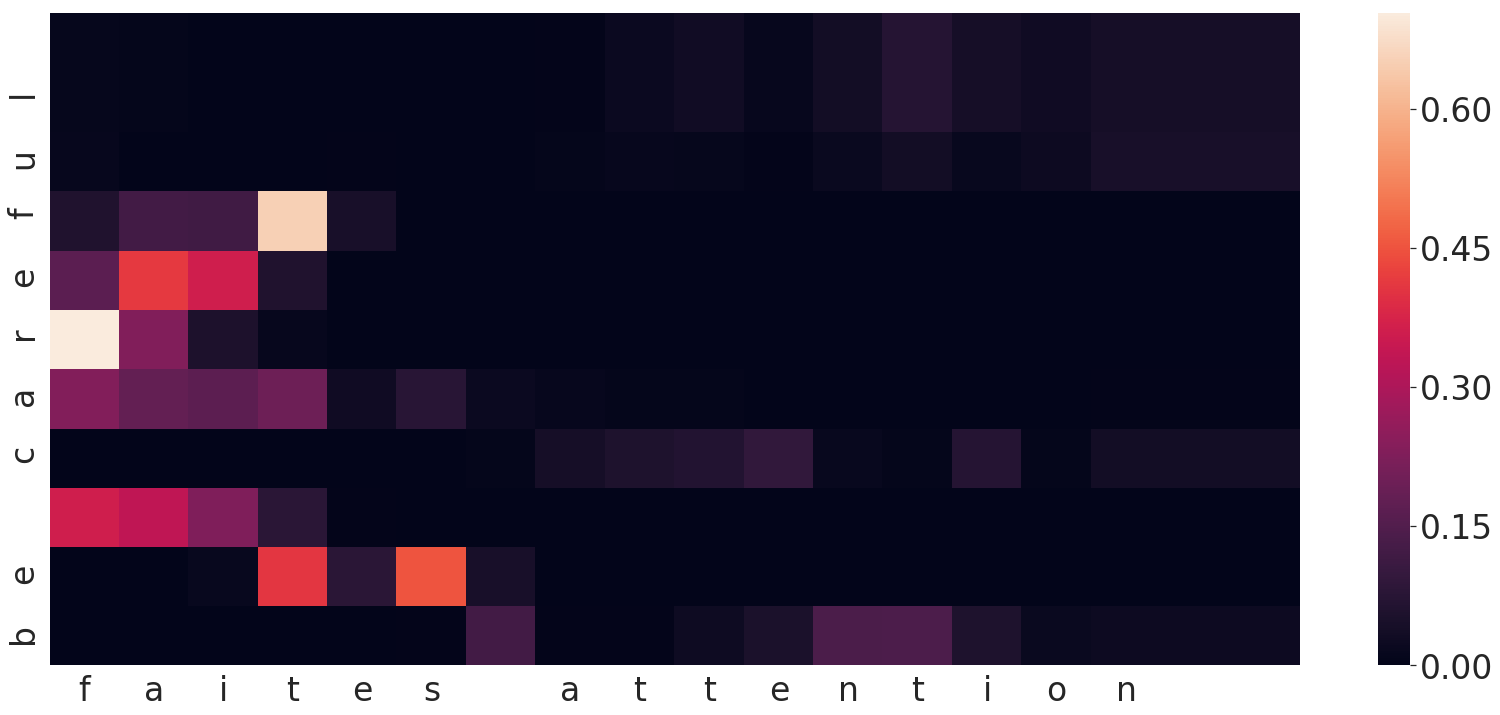

In [64]:
visualize(fra_test[92]);

In [ ]:
eng_test[0]